# Turing Pattern Oscillator in One Dimension

This example illustrates how to set up a oscillatory Turing pattern 
in 1-D using reaction diffusion calculations.
Reaction system is::

    s ---a---> a  // s goes to a, catalyzed by a.
    s ---a---> b  // s goes to b, catalyzed by a.
    a ---b---> s  // a goes to s, catalyzed by b.
    b -------> s  // b is degraded irreversibly to s.

in sum, **a** has a positive feedback onto itself and also forms **b**.
**b** has a negative feedback onto **a**.
Finally, the diffusion constant for **a** is 1/10 that of **b**.

This chemical system is present in a 1-dimensional (cylindrical) 
compartment. The entire reaction-diffusion system is set up 
within the script.


Note, this model gives an error when consecutively run twice. If the error shows up, Go to ``Kernel`` in the toolbar above and click ``Restart Kernel`` or click the restart button to the left of ``Run`` above (the semicircular arrow). 

Hit 'enter' to exit


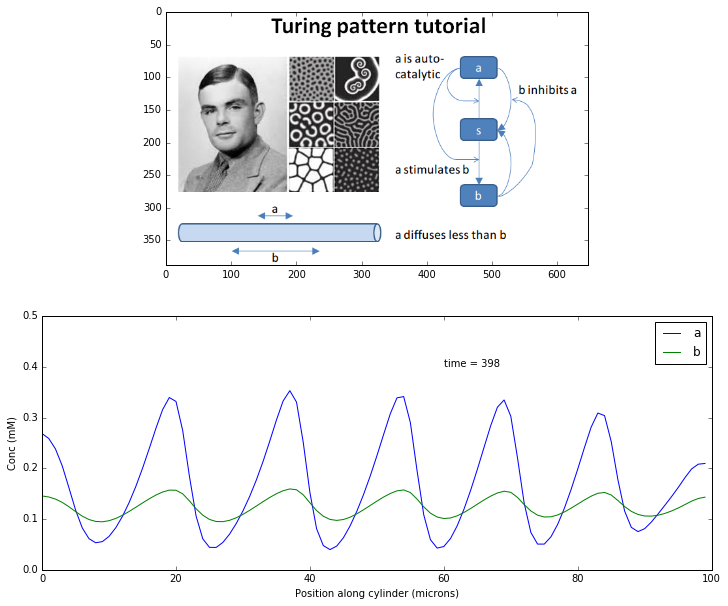

In [1]:
#########################################################################
## This program is part of 'MOOSE', the
## Messaging Object Oriented Simulation Environment.
##           Copyright (C) 2014 Upinder S. Bhalla. and NCBS
## It is made available under the terms of the
## GNU Lesser General Public License version 2.1
## See the file COPYING.LIB for the full notice.
#########################################################################

%matplotlib inline

import math
import numpy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moose

def makeModel():
    
    # create container for model
    r0 = 1e-6	# m
    r1 = 1e-6	# m
    num = 100
    diffLength = 1e-6 # m
    len = num * diffLength	# m
    diffConst = 5e-12 # m^2/sec
    motorRate = 1e-6 # m/sec
    concA = 1 # millimolar
    dt4 = 0.02  # for the diffusion
    dt5 = 0.2   # for the reaction

    model = moose.Neutral( 'model' )
    compartment = moose.CylMesh( '/model/compartment' )
    compartment.r0 = r0
    compartment.r1 = r1
    compartment.x0 = 0
    compartment.x1 = len
    compartment.diffLength = diffLength
    
    assert( compartment.numDiffCompts == num )

    # create molecules and reactions
    a = moose.Pool( '/model/compartment/a' )
    b = moose.Pool( '/model/compartment/b' )
    s = moose.Pool( '/model/compartment/s' )
    e1 = moose.MMenz( '/model/compartment/e1' )
    e2 = moose.MMenz( '/model/compartment/e2' )
    e3 = moose.MMenz( '/model/compartment/e3' )
    r1 = moose.Reac( '/model/compartment/r1' )
    moose.connect( e1, 'sub', s, 'reac' )
    moose.connect( e1, 'prd', a, 'reac' )
    moose.connect( a, 'nOut', e1, 'enzDest' )
    e1.Km = 1
    e1.kcat = 1

    moose.connect( e2, 'sub', s, 'reac' )
    moose.connect( e2, 'prd', b, 'reac' )
    moose.connect( a, 'nOut', e2, 'enzDest' )
    e2.Km = 1
    e2.kcat = 0.5

    moose.connect( e3, 'sub', a, 'reac' )
    moose.connect( e3, 'prd', s, 'reac' )
    moose.connect( b, 'nOut', e3, 'enzDest' )
    e3.Km = 0.1
    e3.kcat = 1

    moose.connect( r1, 'sub', b, 'reac' )
    moose.connect( r1, 'prd', s, 'reac' )
    r1.Kf = 0.3 # 1/sec
    r1.Kb = 0 # 1/sec

    # Assign parameters
    a.diffConst = diffConst/10
    b.diffConst = diffConst
    s.diffConst = 0

    # Make solvers
    ksolve = moose.Ksolve( '/model/compartment/ksolve' )
    dsolve = moose.Dsolve( '/model/dsolve' )
    # Set up clocks. The dsolver to know before assigning stoich
    moose.setClock( 4, dt4 )
    moose.setClock( 5, dt5 )
    moose.useClock( 4, '/model/dsolve', 'process' )
    # Ksolve must be scheduled after dsolve.
    moose.useClock( 5, '/model/compartment/ksolve', 'process' )

    stoich = moose.Stoich( '/model/compartment/stoich' )
    stoich.compartment = compartment
    stoich.ksolve = ksolve
    stoich.dsolve = dsolve
    stoich.path = "/model/compartment/##"
    assert( dsolve.numPools == 3 )
    a.vec.concInit = [0.1]*num
    a.vec[0].concInit *= 1.2 # slight perturbation at one end.
    b.vec.concInit = [0.1]*num
    s.vec.concInit = [1]*num

def displayPlots():
    a = moose.element( '/model/compartment/a' )
    b = moose.element( '/model/compartment/b' )
    pos = numpy.arange( 0, a.vec.conc.size, 1 )
    pylab.plot( pos, a.vec.conc, label='a' )
    pylab.plot( pos, b.vec.conc, label='b' )
    pylab.legend()
    pylab.show()

def main():
    runtime = 400
    displayInterval = 2
    makeModel()
    dsolve = moose.element( '/model/dsolve' )
    moose.reinit()
    #moose.start( runtime ) # Run the model for 10 seconds.

    a = moose.element( '/model/compartment/a' )
    b = moose.element( '/model/compartment/b' )
    s = moose.element( '/model/compartment/s' )

    img = mpimg.imread( 'turingPatternTut.png' )
    #imgplot = plt.imshow( img )
    #plt.show()

    plt.ion()
    fig = plt.figure( figsize=(12,10) )
    png = fig.add_subplot(211)
    imgplot = plt.imshow( img )
    ax = fig.add_subplot(212)
    ax.set_ylim( 0, 0.5 )
    plt.ylabel( 'Conc (mM)' )
    plt.xlabel( 'Position along cylinder (microns)' )
    pos = numpy.arange( 0, a.vec.conc.size, 1 )
    line1, = ax.plot( pos, a.vec.conc, label='a' )
    line2, = ax.plot( pos, b.vec.conc, label='b' )
    timeLabel = plt.text(60, 0.4, 'time = 0')
    plt.legend()
    fig.canvas.draw()

    for t in range( displayInterval, runtime, displayInterval ):
        moose.start( displayInterval )
        line1.set_ydata( a.vec.conc )
        line2.set_ydata( b.vec.conc )
        timeLabel.set_text( "time = %d" % t )
        fig.canvas.draw()

    print( "Hit 'enter' to exit" )


# Run the 'main' if this script is executed standalone.
if __name__ == '__main__':
	main()